<a href="https://colab.research.google.com/github/penguin1109/ArVix-Implementing-papers/blob/main/%F0%9F%90%A8Generative_Models_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### `GAN`
```
1. Training Discriminator
- Freeze the generator's weight
- Generate fake samples from random noise using generator.
- Sample the real samples
- Train discriminator using real and fake samples. (Make real and fake labels)  

2. Training Generator
- Freeze the discriminator weight
- Generate fake samples from the generator
- Train the generator using the discriminator ouptut with the generated fake samples.
```


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


### `VAEGAN: Variational Auto Encoder + GAN`
```
- VAEGAN에 있는 VAE가 입력 이미지를 받아서 latent space로 바꾸어 준 뒤에 VAE의 decoder에 의해서 Fake 이미지가 reconstruct 된다.
- 다만 일반 VAE와의 차이라고 한다면 output 이미지에 대해서 REAL / FAKE여부를 GAN에서의 discriminator이 판별한다는 것이다.
- KL Divergence(Latent에 대해) + Adversarial Loss(Reconstructed Image에 대해) + Reconstruction Loss(Recosntructed Image에 대해)

```

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms

import os
import cv2
import numpy as np

In [ ]:
import zipfile

zipf = zipfile.ZipFile('/content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/archive (1).zip')
zipf.extractall('/content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/face')

In [ ]:
# It is said that unzipping files from the VM disk is much more faster than reading each file individually from the drive.
!unzip '/content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/archive (1).zip' -d "/content"

In [ ]:
# !rm -rf '/content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/archive (1).zip'

In [ ]:
CELEBA_DIR = '/content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/face/img_align_celeba/img_align_celeba'
#CELEBA_DIR = "/content/"
CELEBA_FILES = os.listdir(CELEBA_DIR)
import numpy as np
print(f"#of Files: {len(CELEBA_FILES)} / {len(np.unique(CELEBA_FILES))}")

#of Files: 175414 / 175414


In [ ]:
from tqdm import tqdm
for fname in tqdm(CELEBA_FILES):
  fpath = os.path.join(CELEBA_DIR, fname)
  try:
    img = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
  except:
    print(fname)

  3%|▎         | 5411/161000 [1:15:20<33:54:47,  1.27it/s]

162653.jpg


  3%|▎         | 5413/161000 [1:15:22<35:01:10,  1.23it/s]

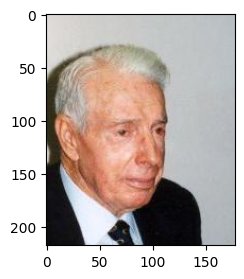

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
sample = cv2.imread(os.path.join(CELEBA_DIR, CELEBA_FILES[77777]))
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
plt.imshow(sample)

In [ ]:
class VAEGAN_dataset(Dataset):
  def __init__(self, data_root):
    super(VAEGAN_dataset, self).__init__()
    self.data_root = data_root
    self.image_files = list(os.listdir(self.data_root))
    self.transform = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.5, std = 0.5)
    ])
  
  def __len__(self):
    return len(self.image_files)
  
  def __getitem__(self, idx):
    image_f = os.path.join(self.data_root, self.image_files[idx])
    image = cv2.imread(image_f)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor_image = self.transform(image)

    return tensor_image
    




``` py
recon_images, mu, log_var = vae(real_images)
recon_loss = criterion_generator(recon_images, real_images) ## 일반적인 L2 Loss = Reconstruction Loss
kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
```



In [ ]:
# VAEGAN에서는 VAE + D_{img}를 학습 시키는 것이라고 생각하면 된다.
# VAE는 KL Divergence를 사용해서 latent vector z를 학습을 시키고, 이때 normal distribution과 가깝도록 한다.
# 그리고 discriminator이 하나가 추가가 되어서 입력 이미지 x가 REAL, 출력 이미지는 FALSE인데 discriminator을 학습 시키기도 하면서 동시에 
# VAE의 decoder도 같이 학습을 시킨다.

"""
class Generator(nn.Module):
  def __init__(self, latent_dim, input_size, output_channel=3):
    # VAE에서의 Encoder에 의해서 만들어진 latent vector을 입력으로 받아서 fake image를 만드는 모듈이다.
    super(Generator, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.fc = nn.Sequential(
        nn.Linear(self.latent_dim, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(2048, input_size * input_size * 128),
        nn.BatchNorm1d(input_size * input_size * 128),
        nn.ReLU()
    )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size = 3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, output_channel, kernel_size = 3, stride=2, padding=1, output_padding=1),
        nn.Tanh() # 이건 왜?
    )
  
  def forward(self, x):
    x = self.fc(x)
    B, L = x.shape
    x = x.view(B, -1, self.input_size, self.input_size)
    x = self.conv(x)

    return x
"""


class Discriminator(nn.Module):
  def __init__(self, input_size, input_channel=3):
    # VAE의 Encoder -> Decoder을 모두 거쳐서 reconstruct된 Fake 이미지에 대한 진위여부를 판단하는 모듈이다.
    super(Discriminator, self).__init__()
    self.input_size = input_size
    self.conv = nn.Sequential(
        nn.Conv2d(input_channel, 64, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace = True), nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True)
    )
    self.fc = nn.Sequential(
        nn.Linear(128 * input_size * input_size, 1024),
        nn.BatchNorm1d(1024), nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(1024, 1), nn.Sigmoid()
    )
  
  def forward(self, x):
    x = self.conv(x)
    B, C, H, W  = x.shape
    x = x.view(-1, C*H*W)
    x = self.fc(x)

    return x
    

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, input_size, output_channel=3):
    # VAE에서의 Encoder에 의해서 만들어진 latent vector을 입력으로 받아서 fake image를 만드는 모듈이다.
    super(Decoder, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.fc = nn.Sequential(
        nn.Linear(self.latent_dim, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(2048, input_size * input_size * 128),
        nn.BatchNorm1d(input_size * input_size * 128),
        nn.ReLU()
    )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size = 3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, output_channel, kernel_size = 3, stride=2, padding=1, output_padding=1),
        nn.Tanh() # 이건 왜?
    )
  
  def forward(self, x):
    x = self.fc(x)
    B, L = x.shape
    x = x.view(B, -1, self.input_size, self.input_size)
    x = self.conv(x)

    return x



### `Adversarial Auto Encoder`
```
1. reparam: reparameterization trick를 사용하기 위한 함수
2. Encoder: X -> Z로 차원 축소해 주는 인코더
3. Decoder: Z -> X'로 복원하고자 하는 디코더
4. Discriminator: 단순한 Auto Encoder과 다르게 GAN에서 사용하는 adversarial training을 한다. 


[LOSSES]
1. adversarial loss
2. pixelwise loss
```

In [ ]:
def reparam(mu, logvar):
  B, L = mu.shape
  std = torch.exp(logvar/2)
  z = torch.normal(0, 1, (mu.size(0), L)).to(mu.device)

  return mu + z * std

class VAEEncoder(nn.Module):
  def __init__(self, latent_dim, input_size, input_channel):
    super(VAEEncoder, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(input_channel, 64, kernel_size = 3, stride = 2, padding=1),
        nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
        nn.BatchNorm2d(128), nn.ReLU(inplace=True)
    )
    self.decoder_in_size = input_size // 4
    self.fc_ch = self.decoder_in_size * self.decoder_in_size * 128
    self.mu = nn.Linear(self.fc_ch, latent_dim)
    self.logvar = nn.Linear(self.fc_ch, latent_dim)
  
  def forward(self, x):
    x = self.conv(x)
    B, C, H, W = x.shape
    x = x.view(B, C*H*W)
    mu = self.mu(x)
    logvar = self.logvar(x)
    z = reparam(mu, logvar)

    return z



In [ ]:
if __name__ == "__main__":
  x = torch.rand((2, 3, 64, 64))
  VAEE = VAEEncoder(128, 64, 3)
  out = VAEE(x)
  print(f"OUTPUT OF VAE ENCODER: {out.shape}")

OUTPUT OF VAE ENCODER: torch.Size([2, 128])


In [ ]:
class VAEDecoder(nn.Module):
  def __init__(self, latent_dim, input_size, output_channel):
    super(VAEDecoder, self).__init__()
    ch = input_size * input_size * 128
    self.input_size = input_size
    self.fc = nn.Sequential(
        nn.Linear(latent_dim, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
        nn.Linear(1024, ch), nn.BatchNorm1d(ch), nn.ReLU()
    )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size = 3, padding=1, stride=2, output_padding=1),
        nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64, output_channel, kernel_size=3, padding=1, stride=2, output_padding=1),
        nn.BatchNorm2d(output_channel), nn.Tanh()
    )
  def forward(self, z):
    z = self.fc(z)
    B, L = z.shape
    x =z.view(B, -1, self.input_size, self.input_size)
    x = self.conv(x)
  
    return x
    

In [ ]:
if __name__ == "__main__":
  z = torch.rand((2, 128))
  VAED = VAEDecoder(128, 16, 3)
  out = VAED(z)
  print(f"OUTPUT OF VAE DECODER: {out.shape}")

OUTPUT OF VAE DECODER: torch.Size([2, 3, 64, 64])


In [ ]:
class VAEDiscriminator_Z(nn.Module):
  # Discriminator for the latent vector Z
  def __init__(self, latent_dim):
    super(VAEDiscriminator_Z, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256), nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 1), nn.Sigmoid()
    )
  
  def forward(self, z):
    return self.model(z)


In [ ]:
if __name__ == "__main__":
  z = torch.rand((2, 128))
  VAEDZ = VAEDiscriminator_Z(128)
  out = VAEDZ(z)
  print(f"OUTPUT OF VAE Z DISCRIMINATOR: {out.shape}")

OUTPUT OF VAE Z DISCRIMINATOR: torch.Size([2, 1])


In [ ]:
class VAEDiscriminator_Img(nn.Module):
  def __init__(self, channel_in, input_size):
    super(VAEDiscriminator_Img, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(channel_in, 64, kernel_size=3, padding=1, stride=2),\
        nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
        nn.BatchNorm2d(128), nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
        nn.BatchNorm2d(256), nn.ReLU()
    )
    output_size = input_size // (2 ** 3)
    fc_ch = (output_size ** 2) * 256
    self.fc = nn.Sequential(
        nn.Linear(fc_ch, 1), nn.Sigmoid()
    )
  
  def forward(self, x):
    x = self.model(x)
    B, C, H, W = x.shape
    x = x.view(B, -1)
    out = self.fc(x)
    return out

In [ ]:
if __name__ == "__main__":
  x = torch.randn((2, 1, 64, 64))
  VAEI = VAEDiscriminator_Img(1, 64)
  out = VAEI(x)
  print(f"OUTPUT OF VAE IMG DISCRIMINAOTR: {out.shape}")

OUTPUT OF VAE IMG DISCRIMINAOTR: torch.Size([2, 1])


In [ ]:
import random
class VAEGAN_dataset(Dataset):
  def __init__(self, data_root, mode = 'train'):
    super(VAEGAN_dataset, self).__init__()
    self.data_root = data_root
    self.image_files = list(os.listdir(self.data_root))
    self.transform = transforms.Compose([
        transforms.ToPILImage(), # PIL Image로 이미지를 읽어야 Resize가 가능하다.
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5,0.5,0.5],std=[0.5,0.5,0.5])
    ])
    self.mode = mode
    if mode == 'test':
      self.image_files = self.image_files[int(len(self.image_files) * 0.9):]
    else:
      self.image_files = self.image_files[:int(len(self.image_files) * 0.9)]
    
  
  def __len__(self):
    if self.mode == 'test':
      return len(self.image_files)
    
    return int(len(self.image_files) * 0.1) # train
  
  def __getitem__(self, idx):
    while True:
      image_f = os.path.join(self.data_root, self.image_files[idx])
      image = cv2.imread(image_f)
      try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        tensor_image = self.transform(image)
        break
      except:
        idx += 1

    return tensor_image
    


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import itertools

batch_size = 128
lr = 2e-4
latent_dim = 128
epoch_n = 20
input_size=64
input_channel=3
# beta 1, 2는 optimizer의 weight decay rate에 영향을 주는 파라미터이다.
b1 = 0.5
b2 = 0.999

# IMG_DISCRIMINATOR = True # False

data_root = '/content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/face/img_align_celeba/img_align_celeba'

adversarial_loss = torch.nn.BCELoss()
reconstruction_loss = torch.nn.L1Loss()


dataset = VAEGAN_dataset(data_root, mode='train')
print(f"Number of Files in the Dataset: {len(dataset)}")
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

encoder = VAEEncoder(latent_dim=latent_dim, input_size=input_size, input_channel=input_channel).to(device)
decoder = VAEDecoder(latent_dim=latent_dim, input_size=encoder.decoder_in_size, output_channel=input_channel).to(device)
discriminator_z = VAEDiscriminator_Z(latent_dim=latent_dim).to(device)
discriminator_img = VAEDiscriminator_Img(channel_in=3, input_size=input_size).to(device)

opt_G = torch.optim.Adam(itertools.chain(
    encoder.parameters(), decoder.parameters()
), lr=lr, betas = (b1, b2))

opt_DZ = torch.optim.Adam(discriminator_z.parameters(), lr=lr, betas=(b1, b2))
opt_DI =  torch.optim.Adam(discriminator_img.parameters(), lr=lr, betas=(b1, b2))

Number of Files in the Dataset: 15787


In [ ]:
print(f"Number of Image Files in the Dataset: {len(dataset.image_files)}")

Number of Image Files in the Dataset: 157872


In [ ]:
from tqdm import tqdm
loop = tqdm(dataloader)
for idx, batch in enumerate(loop):
  loop.set_postfix({"SHAPE": batch.shape})
  

100%|██████████| 119/119 [2:54:26<00:00, 87.96s/it, SHAPE=torch.Size([36, 3, 64, 64])]


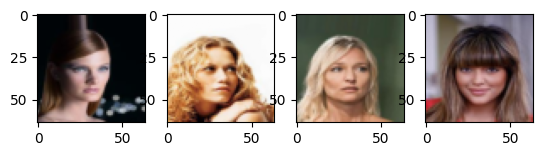

In [ ]:
import matplotlib.pyplot as plt
for i in range(4):
  img = torch.permute(batch[i].detach(), (1,2,0)).cpu().numpy()
  plt.subplot(1, 4, i+1)
  original_img = img * 0.5 + 0.5 
  # original_img *= 255.
  plt.imshow(original_img)

In [ ]:
import matplotlib.pyplot as plt

def change_min_max(mat, new_min=0, new_max=1):
  M, m = mat.max(), mat.min()
  new_mat = ((mat-m) * (new_max-new_min)) / (M-m)
  new_mat += new_min
  return new_mat

def save_images(encoder, decoder, latent_dim, epoch, device):
  # input_noise = torch.normal(0, 1, (25, latent_dim)).to(device)
  # 원래대로라면 입력 이미지에 대해서 만드는 것이긴 하다.
  # training 시에는 학습되지 않았던 이미지로부터 ENCODER이 latent vector z를 만들고
  # DECODER이 이 latent vector z를 reconstruct해서 이미지를 생성한다.
  # 그래서 AAE를 사용해서 anomaly detection을 한다는 것은 NORMAL LATENT VECTOR을 만든느 것을 학습 하였다는 뜻이기도 하다.
  test_dataset = VAEGAN_dataset(data_root, 'test')
  dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=False)
  cnt = 0
  
  os.makedirs(f"{RESULT_DIR}/AAEGAN_{epoch}", exist_ok= True)
  encoder.eval(); decoder.eval();
  for idx, batch in enumerate(dataloader):
    image = batch.to(device)
    encoded_noise = encoder(image)
    decoded_noise = decoder(encoded_noise)

    for b in range(decoded_noise.size(0)):
      img = decoded_noise[b]
      img = torch.permute(img, (1, 2, 0)).detach().cpu().numpy()
      # img = img * 0.5 + 0.5 # 정규화 해 놓은 mean, std 계산하여 복원 -> 이건 Tensor Normalized 이미지를 변환할때 필요한거였음!
      img = change_min_max(img, new_min=0, new_max=1)

      # cv2.imwrite(os.path.join(f"{RESULT_DIR}/AAEGAN_{epoch}/{cnt}.jpg"), img)
      if idx == 0: # 첫번째 batch의 결과들만 저장을 하도록 한다.
        plt.imsave(os.path.join(f"{RESULT_DIR}/AAEGAN_{epoch}/{cnt}.jpg"), img)
        cnt += 1
  
  encoder.train(); decoder.train();

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_weights(net, fname):
  save_path = f"{RESULT_DIR}/{fname}.pth"
  torch.save(net.state_dict(), save_path)
  print(f"SAVED WEIGHT OF {fname} to {save_path}")

In [ ]:
save_weights(encoder, "encoder")

SAVED WEIGHT OF encoder to /content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/results/encoder.pth


`- 여기서 궁금증이 생기는데, discriminator과 generator의 gradient update의 순서는 정해져 있지 않은 것인가??`

In [ ]:
import glob

def get_latest_epoch(dir):
  files = glob.glob(dir + "/*.pth")
  files = sorted(files, reverse=True)
  try:
    latest_epoch = files[0].split('.')[0].split('_')[-1]
  except:
    latest_epoch = None
  return latest_epoch


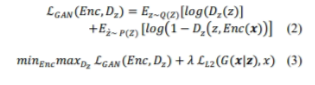

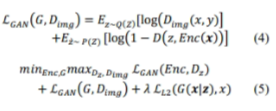

#### `Training the AAEGAN (AAE + Discriminator_Img)`

In [ ]:
from tqdm import tqdm
import random

RESULT_DIR = '/content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/results_aaegan'
os.makedirs(RESULT_DIR, exist_ok=True)

reconstruct_lambda = 0.99 # 100

latest_epoch = None # get_latest_epoch(RESULT_DIR)

if latest_epoch is not None: # 미리 학습 시켜 놓았던 가중치가 있는 경우에만 state_dict_load를 한다.
  if os.path.isfile(f"{RESULT_DIR}/encoder_epoch_{latest_epoch}.pth"):
    encoder.load_state_dict(torch.load(f"{RESULT_DIR}/encoder_epoch_{latest_epoch}.pth"))
  if os.path.isfile(f"{RESULT_DIR}/decoder_epoch_{latest_epoch}.pth"):
    decoder.load_state_dict(torch.load(f"{RESULT_DIR}/decoder_epoch_{latest_epoch}.pth"))
  if os.path.isfile(f"{RESULT_DIR}/discriminator_epoch_{latest_epoch}.pth"):
    discriminator_z.load_state_dict(torch.load(f"{RESULT_DIR}/discriminator_epoch_{latest_epoch}.pth"))
  if os.path.isfile(f"{RESULT_DIR}/discriminatorI_epoch_{latest_epoch}.pth"):
    discriminator_img.load_state_dict(torch.load(f"{RESULT_DIR}/discriminatorI_epoch_{latest_epoch}.pth"))
else:
  latest_epoch = 0

for epoch in range(int(latest_epoch), int(latest_epoch) + epoch_n):
  random.shuffle(dataloader.dataset.image_files) # shuffle the images to train with different images..
  train_loop = tqdm(dataloader)
  encoder.train(); decoder.train(); discriminator_z.train();discriminator_img.train();
  for idx, batch in enumerate(train_loop):
    true_labels = Variable(torch.Tensor(batch.shape[0], 1).fill_(1.0), requires_grad=False).to(device) # Discriminator를 학습 시킬 때는 올바르게 target label로 넣어준다.
    false_labels = Variable(torch.Tensor(batch.shape[0], 1).fill_(0.0), requires_grad=False).to(device) 

    # Configure Input
    # real_imgs = Variable(batch.type(torch.Tensor), device=device)
    real_imgs = batch.to(device)

    # -----------------
    # Train Generator
    # -----------------
    opt_G.zero_grad()
    encoded_imgs = encoder(real_imgs)
    decoded_imgs = decoder(encoded_imgs) # reconstructed image

    # Generator Loss
    discriminate_lambda = (1 - reconstruct_lambda) / 2.
    g_loss = discriminate_lambda * adversarial_loss(discriminator_z(encoded_imgs), true_labels) + reconstruct_lambda * reconstruction_loss(decoded_imgs, real_imgs)  + \
               discriminate_lambda * adversarial_loss(discriminator_img(decoded_imgs), true_labels)
    g_loss /= (2. + reconstruct_lambda)
    # g_loss = (1. - reconstruct_lambda) * adversarial_loss(discriminator_img(decoded_imgs), true_labels) + reconstruct_lambda * reconstruction_loss(decoded_imgs, real_imgs)

    g_loss.backward()
    opt_G.step()

    # ----------------------
    # Train Discriminator_Z
    # ----------------------
    opt_DZ.zero_grad()
    z = torch.normal(0, 1, (batch.shape[0], latent_dim)).to(device) # AAE에서 만드는 latent vector z의 target distribution이 NORMAL DISTRIBUTION이기 때문이다.

    # Discriminator_Z Loss
    real_loss = adversarial_loss(discriminator_z(z), true_labels) # SAMPLED Z를 TRUE로
    ## 앞서서 generator학습 시킬 때에도 encoded_imgs를 사용하여 gradient update를 했었는데, discriminator학습을 위해서도 
    ## encoeded_imgs가 필요하다. 그렇다면 여기서 backward graph를 두번 업데이트 하지 않기 위해서는 
    ## g_loss.backward(retain_graph=True)로 하거나 encoeded_imgs에는 gradient update가 필요 없음을 명시해야 한다.
    ## GAN 학습 시에는 후자가 맞는데, 그 이유는 딱 DISCRIMINATOR만 학습 시키기를 원하는 상황이기 때문이다.
    fake_loss = adversarial_loss(discriminator_z(encoded_imgs.detach()), false_labels) # GENERATED Z를 FALSE로
    # fake_loss = adversarial_loss(discriminator_z(encoded_imgs), false_labels)
    dz_loss = 0.5 * (real_loss + fake_loss)
    dz_loss.backward()
    opt_DZ.step()

    # ------------------------
    # Train Discriminator_Img 
    # ------------------------
    opt_DI.zero_grad()
    
    # Discriminator_Img Loss
    real_loss = adversarial_loss(discriminator_img(real_imgs), true_labels)
    fake_loss = adversarial_loss(discriminator_img(decoded_imgs.detach()), false_labels)
    di_loss = 0.5 * (real_loss + fake_loss)
    di_loss.backward()
    opt_DI.step()

    train_loop.set_postfix({
        "DZ LOSS" : dz_loss.item(), "DI LOSS": di_loss.item(), "G LOSS": g_loss.item()
    })
    if epoch % 5 == 0 and idx+1 == len(dataloader):
      print(
          f"[EPOCH {idx+1} / {len(dataloader)} [DZ loss : {dz_loss.item()}] [G loss: {g_loss.item()}] [DI loss: {di_loss.item()}]"
      )
      save_images(encoder, decoder, latent_dim, epoch, device)
      save_weights(encoder, f"encoder_epoch_{epoch}")
      save_weights(decoder, f"decoder_epoch_{epoch}")
      save_weights(discriminator_z, f"discriminatorZ_epoch_{epoch}")
      save_weights(discriminator_img, f"discriminatorI_epoch_{epoch}")


 99%|█████████▉| 123/124 [3:01:08<01:28, 88.25s/it, DZ LOSS=0.522, DI LOSS=0.176, G LOSS=0.0871]

[EPOCH 124 / 124 [DZ loss : 0.5221917629241943] [G loss: 0.08707205951213837] [DI loss: 0.1762317419052124]
SAVED WEIGHT OF encoder_epoch_0 to /content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/results_aaegan/encoder_epoch_0.pth


100%|██████████| 124/124 [3:02:04<00:00, 88.10s/it, DZ LOSS=0.522, DI LOSS=0.176, G LOSS=0.0871]


SAVED WEIGHT OF decoder_epoch_0 to /content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/results_aaegan/decoder_epoch_0.pth
SAVED WEIGHT OF discriminatorZ_epoch_0 to /content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/results_aaegan/discriminatorZ_epoch_0.pth
SAVED WEIGHT OF discriminatorI_epoch_0 to /content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/results_aaegan/discriminatorI_epoch_0.pth


  1%|          | 1/124 [01:56<1:51:23, 54.34s/it, DZ LOSS=0.354, DI LOSS=0.556, G LOSS=0.0627]

#### `Training the AAE (VAE + Discriminator_Z)`

In [ ]:
from tqdm import tqdm
import random

RESULT_DIR = '/content/drive/MyDrive/internship/🦅Yonsei_Cancer_Medical_Lab/GENERATIVE/results'

latest_epoch = get_latest_epoch(RESULT_DIR)

if latest_epoch:
  if os.path.isfile(f"{RESULT_DIR}/encoder_epoch_{latest_epoch}.pth"):
    encoder.load_state_dict(torch.load(f"{RESULT_DIR}/encoder_epoch_{latest_epoch}.pth"))
  if os.path.isfile(f"{RESULT_DIR}/decoder_epoch_{latest_epoch}.pth"):
    decoder.load_state_dict(torch.load(f"{RESULT_DIR}/decoder_epoch_{latest_epoch}.pth"))
  if os.path.isfile(f"{RESULT_DIR}/discriminator_epoch_{latest_epoch}.pth"):
    discriminator.load_state_dict(torch.load(f"{RESULT_DIR}/discriminator_epoch_{latest_epoch}.pth"))

for epoch in range(int(latest_epoch), int(latest_epoch) + epoch_n):
  random.shuffle(dataloader.dataset.image_files) # shuffle the images to train with different images..
  train_loop = tqdm(dataloader)
  encoder.train(); decoder.train(); discriminator_z.train();
  for idx, batch in enumerate(train_loop):
    true_labels = Variable(torch.Tensor(batch.shape[0], 1).fill_(1.0), requires_grad=False).to(device) # Discriminator를 학습 시킬 때는 올바르게 target label로 넣어준다.
    false_labels = Variable(torch.Tensor(batch.shape[0], 1).fill_(0.0), requires_grad=False).to(device) 

    # Configure Input
    # real_imgs = Variable(batch.type(torch.Tensor), device=device)
    real_imgs = batch.to(device)

    # -----------------
    # Train Generator
    # -----------------
    opt_G.zero_grad()
    encoded_imgs = encoder(real_imgs)
    decoded_imgs = decoder(encoded_imgs)

    # Generator Loss
    g_loss = 0.001 * adversarial_loss(discriminator_z(encoded_imgs), true_labels) + 0.999 * reconstruction_loss(decoded_imgs, real_imgs)
    g_loss.backward()
    opt_G.step()

    # --------------------
    # Train Discriminator
    # --------------------
    opt_DZ.zero_grad()
    z = torch.normal(0, 1, (batch.shape[0], latent_dim)).to(device) # AAE에서 만드는 latent vector z의 target distribution이 NORMAL DISTRIBUTION이기 때문이다.

    # Discriminator Loss
    real_loss = adversarial_loss(discriminator_z(z), true_labels) # SAMPLED Z를 TRUE로
    ## 앞서서 generator학습 시킬 때에도 encoded_imgs를 사용하여 gradient update를 했었는데, discriminator학습을 위해서도 
    ## encoeded_imgs가 필요하다. 그렇다면 여기서 backward graph를 두번 업데이트 하지 않기 위해서는 
    ## g_loss.backward(retain_graph=True)로 하거나 encoeded_imgs에는 gradient update가 필요 없음을 명시해야 한다.
    ## GAN 학습 시에는 후자가 맞는데, 그 이유는 딱 DISCRIMINATOR만 학습 시키기를 원하는 상황이기 때문이다.
    fake_loss = adversarial_loss(discriminator_z(encoded_imgs.detach()), false_labels) # GENERATED Z를 FALSE로
    d_loss = 0.5 * (real_loss + fake_loss)
    d_loss.backward()
    opt_DZ.step()

    train_loop.set_postfix({
        "D LOSS" : d_loss.item(), "G LOSS": g_loss.item()
    })
    if epoch % 5 == 0 and idx+1 == len(dataloader):
      print(
          f"[EPOCH {idx+1} / {len(dataloader)} [D loss : {d_loss.item()}] [G loss: {g_loss.item()}]"
      )
      save_images(encoder, decoder, latent_dim, epoch, device)
      save_weights(encoder, f"encoder_epoch_{epoch}")
      save_weights(decoder, f"decoder_epoch_{epoch}")
      save_weights(discriminator_z, f"discriminator_epoch_{epoch}")


 79%|███████▉  | 469/592 [7:35:40<1:59:30, 58.29s/it, D LOSS=0.544, G LOSS=0.114]

In [ ]:
save_images(encoder, decoder,128, 1, device)

In [ ]:
## DEBUG THE RESULTS ##
test_dataset = VAEGAN_dataset(data_root, 'test')
test_dataloader = DataLoader(test_dataset, batch_size = 10, shuffle=False)
encoder.eval()
decoder.eval()

for idx, batch in enumerate(test_dataloader):
  batch = batch.to(device)
  encoded_noise = encoder(batch)
  img = decoder(encoded_noise)
  
  break

encoder.train()
decoder.train()

In [ ]:
numpy_img = img.detach().cpu().numpy()
test = numpy_img[8]
print(test.shape)


(3, 64, 64)


In [ ]:
test = np.transpose(test, (1, 2, 0))

In [ ]:
def change_zero_one(mat):
  M, m = mat.max(), mat.min()
  return (mat - m) / (M - m)

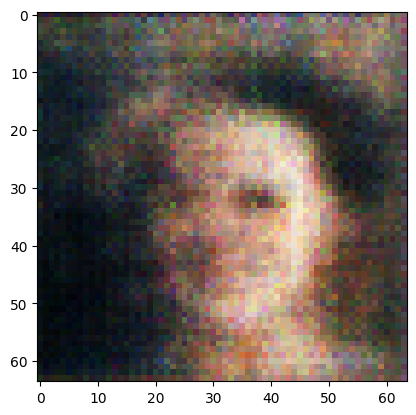

In [ ]:
out = change_zero_one(test)
out = (out * 255).astype(np.uint8)
plt.imshow(out)

In [ ]:
cv2.imwrite("test.png", out)

True

In [ ]:
plt.imsave("test_2.png", out)